In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tensorboardX import SummaryWriter
import copy
import time
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.utils.data as Data
from torchvision import transforms
from torchvision.datasets import FashionMNIST
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToPILImage
from torch.autograd import Variable
import os
from PIL import Image
import torch.nn.functional as F
from torchvision import models

import random
seed=123
deterministic=False

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

In [4]:
#Introduce the attention module.
from attention import se_block,cbam_block,eca_block
attention_blocks=[se_block,cbam_block,eca_block]

In [5]:
## Preprocessing of the set.
train_data_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),# Randomly crop the aspect ratio to 224×224.
    transforms.RandomHorizontalFlip(),# Horizontally flip with a probability of p=0.5.
    transforms.ToTensor(), # Convert to tensors and normalize to the range [0,1].
    ## Image normalization processing.
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_data_transforms = transforms.Compose([
    transforms.Resize(256), # Reset image resolution
    transforms.CenterCrop(224),# Crop from the center according to the given size
    transforms.ToTensor(),# Converted to tensors and normalized to [0-1]
    ## Image standardization processing
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [6]:
## Load the image.

#mini-imagenet
train_data_dir = "dataset\\mini-imagenet\\mini-imagenet\\train"
#tiered_imagenet
# train_data_dir = "dataset\\tiered-imagenet\\tiered_imagenet\\train"


train_data = ImageFolder(train_data_dir, transform=train_data_transforms)
train_data_loader = Data.DataLoader(train_data,batch_size=32,
                                    shuffle=True,num_workers=2)

val_data_dir = "dataset\\mini-imagenet\\mini-imagenet\\val"
# val_data_dir = "dataset\\tiered-imagenet\\tiered_imagenet\\val"


val_data = ImageFolder(val_data_dir, transform=val_data_transforms)
val_data_loader = Data.DataLoader(val_data,batch_size=32,
                                  shuffle=True,num_workers=2)
print("Number of train set samples:",len(train_data.targets))
print("Number of val set samples:",len(val_data.targets))

##  obtain a batch of data.
for step, (b_x, b_y) in enumerate(train_data_loader):  
    if step > 0:
        break

print(b_x.shape)
print(b_y.shape)

训练集样本数: 48000
验证集样本数: 12000
torch.Size([32, 3, 224, 224])
torch.Size([32])


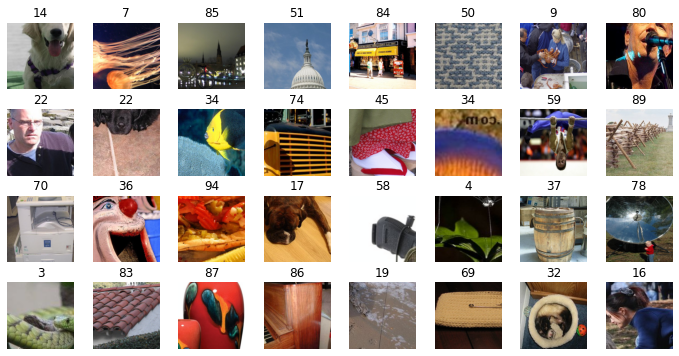

In [7]:
## Visualize the images from one batch of the training set.
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
plt.figure(figsize=(12,6))
for ii in np.arange(len(b_y)):
    plt.subplot(4,8,ii+1)
    image = b_x[ii,:,:,:].numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.title(b_y[ii].data.numpy())
    plt.axis("off")
plt.subplots_adjust(hspace = 0.3)

In [8]:
#use ecanet
#use miniImageNet
#the attention mechanism is added to the conv3
class MyAlexNet_eca_mini_conv3(nn.Module):
    def __init__(self):
        super(MyAlexNetecaminiyxldjqsjzsanc, self).__init__()    
        self.alexnet=models.alexnet(pretrained=True).features
        self.avgpool=nn.AdaptiveAvgPool2d(output_size=(6, 6))
        self.classifier=nn.Sequential(
            nn.Linear(9216,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096,100),
        )
        self.my_attention=eca_block(384)
        
    def forward(self, x):
        x = self.alexnet[0](x)
        x = self.alexnet[1](x)
        x = self.alexnet[2](x)
        x = self.alexnet[3](x)
        x = self.alexnet[4](x)
        x = self.alexnet[5](x)
        x = self.alexnet[6](x)
        x = self.alexnet[7](x)
        x = self.my_attention(x)
        x = self.alexnet[8](x)
        x = self.alexnet[9](x)            
        x = self.alexnet[10](x)
        x = self.alexnet[11](x)
        x = self.alexnet[12](x)
        x = self.avgpool(x)
        x = torch.flatten(x,start_dim=1)
        x = self.classifier(x)
        return x
    
myconvnet = MyAlexNet_eca_mini_conv3()
print(myconvnet)

i=0
for param in myconvnet.alexnet.parameters():     
    if i==0:   
        param.requires_grad=False
    if i==1:   
        param.requires_grad=False
    if i==2:   
        param.requires_grad=False
    if i==3:   
        param.requires_grad=False        
#     if i==4:   
#         param.requires_grad=False        
#     if i==5:   
#         param.requires_grad=False
    if i==6:   
        param.requires_grad=False        
    if i==7:   
        param.requires_grad=False        
    if i==8:   
        param.requires_grad=False        
    if i==9:   
        param.requires_grad=False              
    i=i+1

In [20]:
## Define the training process of the network
def train_model(model,traindataloader, train_rate,criterion, optimizer, num_epochs=25):
    """
    model:Network model；
    traindataloader:training dataset, will be divided into the training set and the val set
    train_rate:training set batchsize percentage;criterion：loss function；optimizer：optimization method；
    num_epochs:the number of training epochs
    """
    ## Calculate the number of batches used for training
    batch_num = len(traindataloader)
    train_batch_num = round(batch_num * train_rate)
    ## Copy the parameters of the model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss_all = []
    train_acc_all = []
    val_loss_all = []
    val_acc_all = []
    since = time.time()
    
    trainlossbaocun=[]
    trainaccbaocun=[]
    vallossbaocun=[]
    valaccbaocun=[]
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # Each epoch has two training phases
        train_loss = 0.0
        train_corrects = 0
        train_num = 0
        val_loss = 0.0
        val_corrects = 0
        val_num = 0
        for step,(b_x,b_y) in enumerate(traindataloader):
            if step < train_batch_num:
                model.train() ## Set the model to training mode
                output = model(b_x)     
                pre_lab = torch.argmax(output,1)
                loss = criterion(output, b_y) 
                optimizer.zero_grad()        
                loss.backward()       
                optimizer.step()  
                train_loss += loss.item() * b_x.size(0)
                train_corrects += torch.sum(pre_lab == b_y.data)
                train_num += b_x.size(0)
            else:
                model.eval() ## Set the model to evaluation mode
                output = model(b_x)     
                pre_lab = torch.argmax(output,1)
                loss = criterion(output, b_y)  
                val_loss += loss.item() * b_x.size(0)
                val_corrects += torch.sum(pre_lab == b_y.data) 
                val_num += b_x.size(0)
        ## Calculate the loss and accuracy of an epoch on the training set and the val set
        train_loss_all.append(train_loss / train_num)
        train_acc_all.append(train_corrects.double().item()/train_num)
        val_loss_all.append(val_loss / val_num)
        val_acc_all.append(val_corrects.double().item()/val_num)
        print('{} Train Loss: {:.4f}  Train Acc: {:.4f}'.format(
            epoch, train_loss_all[-1], train_acc_all[-1]))
        print('{} Val Loss: {:.4f}  val Acc: {:.4f}'.format(
            epoch, val_loss_all[-1], val_acc_all[-1]))
        
        trainlossbaocun.append(train_loss_all[-1])
        trainaccbaocun.append(train_acc_all[-1])
        vallossbaocun.append(val_loss_all[-1])
        valaccbaocun.append(val_acc_all[-1])

        if  val_acc_all[-1] > best_acc:
            best_acc = val_acc_all[-1]
            best_model_wts = copy.deepcopy(model.state_dict())
        time_use = time.time() - since
        print("Train and val complete in {:.0f}m {:.0f}s".format(
            time_use // 60, time_use % 60))
    model.load_state_dict(best_model_wts)
    train_process = pd.DataFrame(
        data={"epoch":range(num_epochs),
              "train_loss_all":train_loss_all,
              "val_loss_all":val_loss_all,
              "train_acc_all":train_acc_all,
              "val_acc_all":val_acc_all})
    
    np.savetxt('loss\\trainlossbaocun-MyAlexNet_eca_mini_conv3.txt',trainlossbaocun)
    np.savetxt('loss\\trainaccbaocun-MyAlexNet_eca_mini_conv3.txt',trainaccbaocun)
    np.savetxt('loss\\vallossbaocun-MyAlexNet_eca_mini_conv3.txt',vallossbaocun)
    np.savetxt('loss\\valaccbaocun-MyAlexNet_eca_mini_conv3.txt',valaccbaocun)   
    
    return model,train_process

In [21]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, myconvnet.parameters()), lr=0.0003)
criterion = nn.CrossEntropyLoss() 
myconvnet,train_process = train_model(
    myconvnet,train_data_loader, 0.8,
    criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
0 Train Loss: 2.4845  Train Acc: 0.3949
0 Val Loss: 1.8851  val Acc: 0.5247
Train and val complete in 21m 20s
Epoch 1/24
----------
1 Train Loss: 1.9065  Train Acc: 0.5234
1 Val Loss: 1.7182  val Acc: 0.5653
Train and val complete in 45m 34s
Epoch 2/24
----------
2 Train Loss: 1.8390  Train Acc: 0.5412
2 Val Loss: 1.6244  val Acc: 0.5901
Train and val complete in 71m 6s
Epoch 3/24
----------
3 Train Loss: 1.7495  Train Acc: 0.5610
3 Val Loss: 1.5763  val Acc: 0.6026
Train and val complete in 95m 54s
Epoch 4/24
----------
4 Train Loss: 1.7349  Train Acc: 0.5648
4 Val Loss: 1.5470  val Acc: 0.6051
Train and val complete in 120m 44s
Epoch 5/24
----------
5 Train Loss: 1.7195  Train Acc: 0.5693
5 Val Loss: 1.5135  val Acc: 0.6215
Train and val complete in 145m 21s
Epoch 6/24
----------
6 Train Loss: 1.6936  Train Acc: 0.5755
6 Val Loss: 1.5141  val Acc: 0.6233
Train and val complete in 170m 2s
Epoch 7/24
----------
7 Train Loss: 1.6740  Train Acc: 0.5795
7 Val Loss: 1

In [22]:
myconvnet.eval()
shang=0
for i in range(len(val_data)):
    x, y = val_data[i][0], val_data[i][1]
    x = Variable(torch.unsqueeze(x, dim=0).float(), requires_grad=True)
    x = torch.tensor(x)
    with torch.no_grad():
        pred = myconvnet(x)
        predicted, actual = torch.argmax(pred[0]), y      
        print(f'predicted:"{predicted}", Actual:"{actual}"')
        if predicted==actual:
            shang=shang+1
print('ACC:'+str(shang/len(val_data))) 

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"6", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0", Actual:"0"
predicted:"0

predicted:"98", Actual:"2"
predicted:"2", Actual:"2"
predicted:"10", Actual:"2"
predicted:"9", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"59", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"80", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"82", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"2", Actual:"2"
predicted:"78", Actual:"2"
predicted:"40", Actual:"2"
predicted:"2", Actual:"2"
predi

predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"4", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"14", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"24", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"5", Actual:"5"
predicted:"36", Actual:"5"
predicted:"5", Actual:"5"
predicted

predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"10", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"7", Actual:"7"
predicted:"10", Actual:"7"
predicted:"97", Actual:"7"
predicted:"7", Actual:"7"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"49", Actual:"8"
predicted:"8", Actual:"8"
predicted:"7", Actual:"8"
predicted:"72", Actual:"8"
predicted:"8", Actual:"8"
predicted:"57", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"9", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"8", Actual:"8"
predicted:"98", Actual:"8"
predicted:"8", Actual:"8"
predicted:"68", Actual:"8"
pred

predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"77", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"77", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"47", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"77", Actual:"10"
predicted:"77", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"13", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actual:"10"
predicted:"10", Actu

predicted:"12", Actual:"12"
predicted:"13", Actual:"12"
predicted:"17", Actual:"12"
predicted:"17", Actual:"12"
predicted:"12", Actual:"12"
predicted:"11", Actual:"12"
predicted:"19", Actual:"12"
predicted:"13", Actual:"12"
predicted:"19", Actual:"12"
predicted:"13", Actual:"13"
predicted:"15", Actual:"13"
predicted:"13", Actual:"13"
predicted:"13", Actual:"13"
predicted:"11", Actual:"13"
predicted:"15", Actual:"13"
predicted:"25", Actual:"13"
predicted:"24", Actual:"13"
predicted:"19", Actual:"13"
predicted:"15", Actual:"13"
predicted:"13", Actual:"13"
predicted:"24", Actual:"13"
predicted:"13", Actual:"13"
predicted:"15", Actual:"13"
predicted:"15", Actual:"13"
predicted:"13", Actual:"13"
predicted:"13", Actual:"13"
predicted:"25", Actual:"13"
predicted:"12", Actual:"13"
predicted:"13", Actual:"13"
predicted:"85", Actual:"13"
predicted:"13", Actual:"13"
predicted:"13", Actual:"13"
predicted:"14", Actual:"13"
predicted:"13", Actual:"13"
predicted:"15", Actual:"13"
predicted:"29", Actu

predicted:"33", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"85", Actual:"15"
predicted:"22", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"22", Actual:"15"
predicted:"18", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"22", Actual:"15"
predicted:"85", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actual:"15"
predicted:"15", Actu

predicted:"17", Actual:"17"
predicted:"19", Actual:"17"
predicted:"17", Actual:"17"
predicted:"25", Actual:"17"
predicted:"17", Actual:"17"
predicted:"17", Actual:"17"
predicted:"17", Actual:"17"
predicted:"23", Actual:"17"
predicted:"17", Actual:"17"
predicted:"96", Actual:"17"
predicted:"27", Actual:"17"
predicted:"17", Actual:"17"
predicted:"17", Actual:"17"
predicted:"17", Actual:"17"
predicted:"20", Actual:"17"
predicted:"11", Actual:"17"
predicted:"17", Actual:"17"
predicted:"85", Actual:"17"
predicted:"17", Actual:"17"
predicted:"20", Actual:"17"
predicted:"2", Actual:"18"
predicted:"18", Actual:"18"
predicted:"22", Actual:"18"
predicted:"15", Actual:"18"
predicted:"18", Actual:"18"
predicted:"15", Actual:"18"
predicted:"22", Actual:"18"
predicted:"18", Actual:"18"
predicted:"18", Actual:"18"
predicted:"18", Actual:"18"
predicted:"18", Actual:"18"
predicted:"18", Actual:"18"
predicted:"18", Actual:"18"
predicted:"18", Actual:"18"
predicted:"18", Actual:"18"
predicted:"63", Actua

predicted:"15", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"77", Actual:"20"
predicted:"22", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"21", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"15", Actual:"20"
predicted:"20", Actual:"20"
predicted:"99", Actual:"20"
predicted:"79", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"21", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"18", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"20", Actual:"20"
predicted:"22", Actual:"20"
predicted:"20", Actual:"20"
predicted:"21", Actual:"20"
predicted:"20", Actu

predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"25", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"96", Actual:"22"
predicted:"23", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"45", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"2", Actual:"22"
predicted:"33", Actual:"22"
predicted:"22", Actual:"22"
predicted:"15", Actual:"22"
predicted:"22", Actual:"22"
predicted:"23", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"20", Actual:"22"
predicted:"22", Actual:"22"
predicted:"22", Actual:"22"
predicted:"23", Actual:"23"
predicted:"22", Actual:"23"
predicted:"14", Actual:"23"
predicted:"33", Actua

predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"33", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"33", Actual:"25"
predicted:"25", Actual:"25"
predicted:"27", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"33", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actual:"25"
predicted:"25", Actu

predicted:"30", Actual:"30"
predicted:"31", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"2", Actual:"30"
predicted:"17", Actual:"30"
predicted:"30", Actual:"30"
predicted:"98", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"31", Actual:"30"
predicted:"30", Actual:"30"
predicted:"59", Actual:"30"
predicted:"32", Actual:"30"
predicted:"31", Actual:"30"
predicted:"30", Actual:"30"
predicted:"31", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"30", Actual:"30"
predicted:"4", Actual:"30"
predicted:"30", Actual

predicted:"34", Actual:"34"
predicted:"34", Actual:"34"
predicted:"34", Actual:"34"
predicted:"34", Actual:"34"
predicted:"34", Actual:"34"
predicted:"34", Actual:"34"
predicted:"34", Actual:"34"
predicted:"89", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"40", Actual:"35"
predicted:"35", Actual:"35"
predicted:"56", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"81", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"78", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actual:"35"
predicted:"35", Actu

predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"89", Actual:"37"
predicted:"37", Actual:"37"
predicted:"45", Actual:"37"
predicted:"37", Actual:"37"
predicted:"36", Actual:"37"
predicted:"37", Actual:"37"
predicted:"36", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"62", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"56", Actual:"37"
predicted:"37", Actual:"37"
predicted:"5", Actual:"37"
predicted:"89", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"44", Actual:"37"
predicted:"49", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"37", Actual:"37"
predicted:"2", Actual:"37"
predicted:"36", Actual:"37"
predicted:"48", Actual:"37"
predicted:"84", Actual:"37"
predicted:"37", Actual

predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"89", Actual:"39"
predicted:"39", Actual:"39"
predicted:"23", Actual:"39"
predicted:"72", Actual:"39"
predicted:"84", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"61", Actual:"39"
predicted:"84", Actual:"39"
predicted:"39", Actual:"39"
predicted:"39", Actual:"39"
predicted:"47", Actual:"40"
predicted:"40", Actual:"40"
predicted:"40", Actual:"40"
predicted:"40", Actual:"40"
predicted:"40", Actual:"40"
predicted:"8", Actual:"40"
predicted:"40", Actual:"40"
predicted:"40", Actual:"40"
predicted:"40", Actual:"40"
predicted:"58", Actual:"40"
predicted:"40", Actual:"40"
predicted:"89", Actual:"40"
predicted:"40", Actual:"40"
predicted:"0", Actual:"40"
predicted:"2", Actual:"40"
predicted:"40", Actual:"40"
predicted:"40", Actual:

predicted:"61", Actual:"42"
predicted:"34", Actual:"42"
predicted:"67", Actual:"42"
predicted:"70", Actual:"42"
predicted:"39", Actual:"42"
predicted:"42", Actual:"42"
predicted:"42", Actual:"42"
predicted:"69", Actual:"42"
predicted:"42", Actual:"42"
predicted:"42", Actual:"42"
predicted:"42", Actual:"42"
predicted:"70", Actual:"42"
predicted:"42", Actual:"42"
predicted:"42", Actual:"42"
predicted:"70", Actual:"42"
predicted:"38", Actual:"42"
predicted:"36", Actual:"42"
predicted:"42", Actual:"42"
predicted:"70", Actual:"42"
predicted:"42", Actual:"42"
predicted:"42", Actual:"42"
predicted:"48", Actual:"42"
predicted:"42", Actual:"42"
predicted:"70", Actual:"42"
predicted:"48", Actual:"42"
predicted:"36", Actual:"42"
predicted:"42", Actual:"42"
predicted:"48", Actual:"42"
predicted:"53", Actual:"42"
predicted:"61", Actual:"42"
predicted:"42", Actual:"42"
predicted:"94", Actual:"42"
predicted:"94", Actual:"42"
predicted:"42", Actual:"42"
predicted:"69", Actual:"42"
predicted:"91", Actu

predicted:"83", Actual:"44"
predicted:"60", Actual:"44"
predicted:"85", Actual:"44"
predicted:"41", Actual:"44"
predicted:"28", Actual:"44"
predicted:"49", Actual:"44"
predicted:"44", Actual:"44"
predicted:"44", Actual:"44"
predicted:"70", Actual:"44"
predicted:"44", Actual:"44"
predicted:"67", Actual:"44"
predicted:"78", Actual:"44"
predicted:"85", Actual:"44"
predicted:"95", Actual:"44"
predicted:"41", Actual:"44"
predicted:"44", Actual:"44"
predicted:"78", Actual:"44"
predicted:"49", Actual:"44"
predicted:"58", Actual:"44"
predicted:"67", Actual:"44"
predicted:"37", Actual:"44"
predicted:"44", Actual:"44"
predicted:"44", Actual:"44"
predicted:"44", Actual:"44"
predicted:"69", Actual:"44"
predicted:"80", Actual:"44"
predicted:"6", Actual:"44"
predicted:"68", Actual:"44"
predicted:"44", Actual:"44"
predicted:"58", Actual:"45"
predicted:"71", Actual:"45"
predicted:"45", Actual:"45"
predicted:"73", Actual:"45"
predicted:"45", Actual:"45"
predicted:"50", Actual:"45"
predicted:"23", Actua

predicted:"53", Actual:"47"
predicted:"19", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"58", Actual:"47"
predicted:"62", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"60", Actual:"47"
predicted:"61", Actual:"47"
predicted:"51", Actual:"47"
predicted:"67", Actual:"47"
predicted:"53", Actual:"47"
predicted:"66", Actual:"47"
predicted:"53", Actual:"47"
predicted:"70", Actual:"47"
predicted:"47", Actual:"47"
predicted:"73", Actual:"47"
predicted:"70", Actual:"47"
predicted:"35", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"38", Actual:"47"
predicted:"47", Actual:"47"
predicted:"0", Actual:"47"
predicted:"75", Actual:"47"
predicted:"47", Actual:"47"
predicted:"47", Actual:"47"
predicted:"57", Actual:"47"
predicted:"29", Actual:"47"
predicted:"45", Actual:"47"
predicted:"3", Actual

predicted:"60", Actual:"49"
predicted:"49", Actual:"49"
predicted:"60", Actual:"49"
predicted:"7", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"37", Actual:"49"
predicted:"2", Actual:"49"
predicted:"49", Actual:"49"
predicted:"60", Actual:"49"
predicted:"49", Actual:"49"
predicted:"87", Actual:"49"
predicted:"58", Actual:"49"
predicted:"81", Actual:"49"
predicted:"66", Actual:"49"
predicted:"49", Actual:"49"
predicted:"57", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"36", Actual:"49"
predicted:"49", Actual:"49"
predicted:"36", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"71", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"49", Actual:"49"
predicted:"63", Actual

predicted:"52", Actual:"52"
predicted:"71", Actual:"52"
predicted:"52", Actual:"52"
predicted:"52", Actual:"52"
predicted:"80", Actual:"52"
predicted:"47", Actual:"52"
predicted:"52", Actual:"52"
predicted:"62", Actual:"52"
predicted:"52", Actual:"52"
predicted:"78", Actual:"52"
predicted:"52", Actual:"52"
predicted:"52", Actual:"52"
predicted:"45", Actual:"52"
predicted:"56", Actual:"52"
predicted:"52", Actual:"52"
predicted:"87", Actual:"52"
predicted:"64", Actual:"52"
predicted:"80", Actual:"52"
predicted:"52", Actual:"52"
predicted:"52", Actual:"52"
predicted:"52", Actual:"52"
predicted:"52", Actual:"52"
predicted:"54", Actual:"52"
predicted:"80", Actual:"52"
predicted:"73", Actual:"52"
predicted:"52", Actual:"52"
predicted:"52", Actual:"52"
predicted:"44", Actual:"52"
predicted:"52", Actual:"52"
predicted:"52", Actual:"52"
predicted:"97", Actual:"52"
predicted:"74", Actual:"52"
predicted:"82", Actual:"52"
predicted:"52", Actual:"52"
predicted:"80", Actual:"52"
predicted:"80", Actu

predicted:"54", Actual:"54"
predicted:"53", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"49", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"61", Actual:"54"
predicted:"54", Actual:"54"
predicted:"29", Actual:"54"
predicted:"56", Actual:"54"
predicted:"45", Actual:"54"
predicted:"54", Actual:"54"
predicted:"71", Actual:"54"
predicted:"72", Actual:"54"
predicted:"60", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"39", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"48", Actual:"54"
predicted:"39", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actual:"54"
predicted:"90", Actual:"54"
predicted:"91", Actual:"54"
predicted:"54", Actual:"54"
predicted:"54", Actu

predicted:"57", Actual:"57"
predicted:"57", Actual:"57"
predicted:"77", Actual:"57"
predicted:"62", Actual:"57"
predicted:"57", Actual:"57"
predicted:"57", Actual:"57"
predicted:"57", Actual:"57"
predicted:"4", Actual:"57"
predicted:"93", Actual:"57"
predicted:"45", Actual:"57"
predicted:"69", Actual:"57"
predicted:"10", Actual:"57"
predicted:"46", Actual:"57"
predicted:"87", Actual:"57"
predicted:"57", Actual:"57"
predicted:"57", Actual:"57"
predicted:"8", Actual:"57"
predicted:"57", Actual:"57"
predicted:"69", Actual:"57"
predicted:"57", Actual:"57"
predicted:"52", Actual:"57"
predicted:"62", Actual:"57"
predicted:"98", Actual:"57"
predicted:"57", Actual:"57"
predicted:"15", Actual:"57"
predicted:"57", Actual:"57"
predicted:"57", Actual:"57"
predicted:"93", Actual:"57"
predicted:"57", Actual:"57"
predicted:"81", Actual:"57"
predicted:"69", Actual:"57"
predicted:"69", Actual:"57"
predicted:"57", Actual:"57"
predicted:"22", Actual:"57"
predicted:"61", Actual:"57"
predicted:"57", Actual

predicted:"59", Actual:"59"
predicted:"80", Actual:"59"
predicted:"42", Actual:"59"
predicted:"85", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"63", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"68", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"39", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"19", Actual:"59"
predicted:"63", Actual:"59"
predicted:"68", Actual:"59"
predicted:"59", Actual:"59"
predicted:"68", Actual:"59"
predicted:"59", Actual:"59"
predicted:"68", Actual:"59"
predicted:"85", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"59", Actual:"59"
predicted:"70", Actual:"59"
predicted:"85", Actual:"59"
predicted:"59", Actual:"59"
predicted:"68", Actual:"59"
predicted:"17", Actu

predicted:"61", Actual:"61"
predicted:"66", Actual:"61"
predicted:"61", Actual:"61"
predicted:"61", Actual:"61"
predicted:"61", Actual:"61"
predicted:"61", Actual:"61"
predicted:"61", Actual:"61"
predicted:"47", Actual:"61"
predicted:"63", Actual:"61"
predicted:"38", Actual:"61"
predicted:"61", Actual:"61"
predicted:"62", Actual:"62"
predicted:"62", Actual:"62"
predicted:"94", Actual:"62"
predicted:"62", Actual:"62"
predicted:"62", Actual:"62"
predicted:"61", Actual:"62"
predicted:"62", Actual:"62"
predicted:"57", Actual:"62"
predicted:"62", Actual:"62"
predicted:"62", Actual:"62"
predicted:"63", Actual:"62"
predicted:"46", Actual:"62"
predicted:"62", Actual:"62"
predicted:"61", Actual:"62"
predicted:"52", Actual:"62"
predicted:"69", Actual:"62"
predicted:"62", Actual:"62"
predicted:"73", Actual:"62"
predicted:"62", Actual:"62"
predicted:"62", Actual:"62"
predicted:"77", Actual:"62"
predicted:"62", Actual:"62"
predicted:"62", Actual:"62"
predicted:"99", Actual:"62"
predicted:"62", Actu

predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"37", Actual:"64"
predicted:"96", Actual:"64"
predicted:"40", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"56", Actual:"64"
predicted:"48", Actual:"64"
predicted:"40", Actual:"64"
predicted:"64", Actual:"64"
predicted:"40", Actual:"64"
predicted:"40", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"35", Actual:"64"
predicted:"40", Actual:"64"
predicted:"35", Actual:"64"
predicted:"2", Actual:"64"
predicted:"2", Actual:"64"
predicted:"64", Actual:"64"
predicted:"80", Actual:"64"
predicted:"43", Actual:"64"
predicted:"5", Actual:"64"
predicted:"64", Actual:"64"
predicted:"56", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"64", Actual:"64"
predicted:"40", Actual:

predicted:"66", Actual:"66"
predicted:"59", Actual:"66"
predicted:"66", Actual:"66"
predicted:"66", Actual:"66"
predicted:"66", Actual:"66"
predicted:"66", Actual:"66"
predicted:"80", Actual:"66"
predicted:"62", Actual:"66"
predicted:"66", Actual:"66"
predicted:"80", Actual:"66"
predicted:"66", Actual:"66"
predicted:"80", Actual:"66"
predicted:"71", Actual:"66"
predicted:"9", Actual:"66"
predicted:"66", Actual:"66"
predicted:"66", Actual:"66"
predicted:"66", Actual:"66"
predicted:"80", Actual:"66"
predicted:"47", Actual:"66"
predicted:"59", Actual:"66"
predicted:"2", Actual:"66"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"48", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual:"67"
predicted:"44", Actual:"67"
predicted:"52", Actual:"67"
predicted:"67", Actual:"67"
predicted:"67", Actual

predicted:"57", Actual:"69"
predicted:"61", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"82", Actual:"69"
predicted:"50", Actual:"69"
predicted:"57", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"50", Actual:"69"
predicted:"52", Actual:"69"
predicted:"57", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"45", Actual:"69"
predicted:"42", Actual:"69"
predicted:"45", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"85", Actual:"69"
predicted:"69", Actual:"69"
predicted:"36", Actual:"69"
predicted:"71", Actual:"69"
predicted:"76", Actual:"69"
predicted:"69", Actual:"69"
predicted:"69", Actual:"69"
predicted:"72", Actu

predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"96", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"83", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"57", Actual:"71"
predicted:"71", Actual:"71"
predicted:"62", Actual:"71"
predicted:"50", Actual:"71"
predicted:"71", Actual:"71"
predicted:"78", Actual:"71"
predicted:"87", Actual:"71"
predicted:"71", Actual:"71"
predicted:"22", Actual:"71"
predicted:"80", Actual:"71"
predicted:"98", Actual:"71"
predicted:"50", Actual:"71"
predicted:"97", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"71", Actual:"71"
predicted:"72", Actual:"72"
predicted:"72", Actual:"72"
predicted:"72", Actual:"72"
predicted:"72", Actual:"72"
predicted:"72", Actu

predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"39", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"59", Actual:"74"
predicted:"56", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"74", Actual:"74"
predicted:"56", Actual:"74"
predicted:"74", Actual:"74"
predicted:"69", Actual:"74"
predicted:"74", Actu

predicted:"36", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"39", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"71", Actual:"76"
predicted:"54", Actual:"76"
predicted:"76", Actual:"76"
predicted:"76", Actual:"76"
predicted:"56", Actu

predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"4", Actual:"79"
predicted:"51", Actual:"79"
predicted:"30", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"89", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"4", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"79", Actual:"79"
predicted:"7", Actual:"79"
predicted:"4", Actual:"79"
predicted:"79", Actual:"79"
predicted:"5", Actual:"79"
predicted:"79", Actual:"7

predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"56", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"40", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"25", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"81", Actual:"81"
predicted:"24", Actual:"81"
predicted:"81", Actual:"81"
predicted:"80", Actual:"81"
predicted:"81", Actual:"81"
predicted:"40", Actual:"81"
predicted:"56", Actual:"81"
predicted:"35", Actu

predicted:"83", Actual:"83"
predicted:"83", Actual:"83"
predicted:"83", Actual:"83"
predicted:"39", Actual:"84"
predicted:"39", Actual:"84"
predicted:"84", Actual:"84"
predicted:"84", Actual:"84"
predicted:"84", Actual:"84"
predicted:"84", Actual:"84"
predicted:"69", Actual:"84"
predicted:"84", Actual:"84"
predicted:"39", Actual:"84"
predicted:"84", Actual:"84"
predicted:"62", Actual:"84"
predicted:"39", Actual:"84"
predicted:"76", Actual:"84"
predicted:"38", Actual:"84"
predicted:"39", Actual:"84"
predicted:"75", Actual:"84"
predicted:"39", Actual:"84"
predicted:"39", Actual:"84"
predicted:"84", Actual:"84"
predicted:"48", Actual:"84"
predicted:"84", Actual:"84"
predicted:"39", Actual:"84"
predicted:"39", Actual:"84"
predicted:"76", Actual:"84"
predicted:"39", Actual:"84"
predicted:"84", Actual:"84"
predicted:"84", Actual:"84"
predicted:"84", Actual:"84"
predicted:"39", Actual:"84"
predicted:"84", Actual:"84"
predicted:"91", Actual:"84"
predicted:"39", Actual:"84"
predicted:"39", Actu

predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"40", Actual:"86"
predicted:"82", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"53", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"75", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"66", Actual:"86"
predicted:"48", Actual:"86"
predicted:"53", Actual:"86"
predicted:"52", Actual:"86"
predicted:"53", Actual:"86"
predicted:"86", Actual:"86"
predicted:"53", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"86", Actual:"86"
predicted:"80", Actual:"86"
predicted:"70", Actual:"86"
predicted:"70", Actual:"86"
predicted:"86", Actual:"86"
predicted:"75", Actual:"86"
predicted:"39", Actu

predicted:"55", Actual:"88"
predicted:"20", Actual:"88"
predicted:"88", Actual:"88"
predicted:"55", Actual:"88"
predicted:"92", Actual:"88"
predicted:"63", Actual:"88"
predicted:"55", Actual:"88"
predicted:"92", Actual:"88"
predicted:"55", Actual:"88"
predicted:"94", Actual:"88"
predicted:"55", Actual:"88"
predicted:"88", Actual:"88"
predicted:"88", Actual:"88"
predicted:"65", Actual:"88"
predicted:"88", Actual:"88"
predicted:"55", Actual:"88"
predicted:"89", Actual:"89"
predicted:"89", Actual:"89"
predicted:"89", Actual:"89"
predicted:"89", Actual:"89"
predicted:"85", Actual:"89"
predicted:"89", Actual:"89"
predicted:"75", Actual:"89"
predicted:"89", Actual:"89"
predicted:"96", Actual:"89"
predicted:"96", Actual:"89"
predicted:"99", Actual:"89"
predicted:"89", Actual:"89"
predicted:"89", Actual:"89"
predicted:"89", Actual:"89"
predicted:"33", Actual:"89"
predicted:"89", Actual:"89"
predicted:"24", Actual:"89"
predicted:"89", Actual:"89"
predicted:"89", Actual:"89"
predicted:"36", Actu

predicted:"91", Actual:"91"
predicted:"63", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"54", Actual:"91"
predicted:"91", Actual:"91"
predicted:"68", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"45", Actual:"91"
predicted:"91", Actual:"91"
predicted:"51", Actual:"91"
predicted:"91", Actual:"91"
predicted:"54", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"58", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"84", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"39", Actual:"91"
predicted:"78", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actual:"91"
predicted:"91", Actu

predicted:"93", Actual:"93"
predicted:"69", Actual:"93"
predicted:"93", Actual:"93"
predicted:"81", Actual:"93"
predicted:"65", Actual:"93"
predicted:"93", Actual:"93"
predicted:"87", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"87", Actual:"93"
predicted:"41", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"41", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"94", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"93", Actual:"93"
predicted:"87", Actual:"93"
predicted:"94", Actual:"94"
predicted:"94", Actual:"94"
predicted:"94", Actual:"94"
predicted:"94", Actual:"94"
predicted:"94", Actual:"94"
predicted:"94", Actual:"94"
predicted:"94", Actual:"94"
predicted:"94", Actual:"94"
predicted:"94", Actu

predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"24", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"73", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actual:"96"
predicted:"96", Actu

predicted:"98", Actual:"98"
predicted:"2", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"57", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"94", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"97", Actual:"98"
predicted:"98", Actual:"98"
predicted:"94", Actual:"98"
predicted:"94", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"23", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"98", Actual:"98"
predicted:"50", Actua

In [23]:
torch.save(myconvnet.state_dict(),'model/MyAlexNet_eca_mini_conv3.pth')